In [80]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import ParameterGrid

from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.linear_model import Ridge, LogisticRegression, LinearRegression, Lasso, ElasticNet
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, fbeta_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import shap

import warnings
warnings.filterwarnings("ignore")

# 0. functions used

In [59]:
# split the dataset into Other set and Test set
def basic_split(X, y, other_size, test_size, random_state):
    # test the inputs
    if (other_size+test_size != 1):
        print("The split size does not add up to 1")
        raise ValueError
    if not isinstance(random_state, int):
        print("The random state entered in not an integer")
        raise ValueError
    if X.shape[0] != y.shape[0]:
        print("The number of rows in X is not the same as the length of y")
        raise ValueError
    if len(X.shape) != 2:
        print("Input X is not a 2-D pandas dataframe")
        raise ValueError
    if len(y.shape) != 1:
        print("Input y is not a 1-D pandas series")
        raise ValueError

    # split the dataset into other and test
    X_other, X_test, y_other, y_test = train_test_split(X, y,
                                                          train_size = other_size, 
                                                          random_state = random_state)
  
    return X_other, y_other, X_test, y_test

# function for the ML pipeline as outlined above 
def MLpipe_KFold_accuracy(X, y, preprocessor, ML_algo, param_grid):

    # lists to be returned 
    test_scores = []
    best_models = []
    model = pd.DataFrame(columns=['best_parameter', 'train_score', 'test_score'])

    for i in range(5):
        print(f'---------Random State = {42*i}---------')
        # split the data
        X_other, X_test, y_other, y_test = train_test_split(X, y, train_size = 0.8, random_state = 42*i)

        # use KFold with 4 folds
        kf = KFold(n_splits=4,shuffle=True,random_state=42*i)

        pipe = make_pipeline(preprocessor,ML_algo)

        # GridSearchCV, loop through all possible parameters
        # preprocess data and perform cross valifation
        grid = GridSearchCV(pipe, param_grid=param_grid,scoring='accuracy',
                        cv=kf, return_train_score = True, n_jobs=-1, verbose=3) # return_train_score = True, n_jobs=-1, verbose=True
        
        grid.fit(X_other, y_other)
        results = pd.DataFrame(grid.cv_results_)

        # calculate and save the test score
        final_model = grid.best_estimator_

        y_train_pred = final_model.predict(X_other)
        train_accuracy= accuracy_score(y_other,y_train_pred)

        y_test_pred = final_model.predict(X_test)
        test_scores.append(accuracy_score(y_test,y_test_pred)) # calculate the rmse
        best_models.append(grid.best_params_) # save the best param 

        model.loc[len(model)] = [grid.best_params_, train_accuracy, accuracy_score(y_test,y_test_pred)]
    
    print('------------acuuracy scores of each random state------------')
    print(model)
    

    return test_scores, best_models, results, model

# 1. before modeling

In [62]:
df = pd.read_csv('data/mushroom/secondary_data.csv', sep=';')
print(df.shape)
df.head()

(61069, 21)


,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,...,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,...,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,...,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,...,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,...,s,y,w,u,w,t,p,NaN,d,w


In [63]:
# convert features
df['does-bruise-or-bleed'] = df['does-bruise-or-bleed'].replace('t', 1)
df['does-bruise-or-bleed'] = df['does-bruise-or-bleed'].replace('f', 0)
df['has-ring'] = df['has-ring'].replace('t', 1)
df['has-ring'] = df['has-ring'].replace('f', 0)

# split the features and target variable
y = df['class']
X = df.drop(columns='class')
print(X.shape, y.shape)

# replace the e with 0, and p with 1
y = y.replace('e', 0)
y = y.replace('p', 1)

# split the dataset
X_other, y_other, X_test, y_test = basic_split(X, y, other_size = 0.8, test_size = 0.2, random_state=42)
print('The shape of each train, val, and test set are the following:')
print('X_other: {a}, X_test: {b}'.format(a=X_other.shape, b=X_test.shape))
print('y_other: {a}, y_test: {b}'.format(a=y_other.shape, b=y_test.shape))

(61069, 20) (61069,)
The shape of each train, val, and test set are the following:
X_other: (48855, 20), X_test: (12214, 20)
y_other: (48855,), y_test: (12214,)


# 2. Define the Preprocessor

In [64]:
# define preprocessors
binary_feature = ['does-bruise-or-bleed', 'has-ring']
onehot_features = ['cap-shape', 'cap-surface', 'cap-color', 'gill-attachment', 'gill-spacing', 'gill-color','stem-root', 
                'stem-surface', 'stem-color', 'veil-type', 'veil-color', 'ring-type', 'spore-print-color', 'habitat', 'season']
std_features = ['cap-diameter','stem-height','stem-width']

# collect all the encoders
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'), onehot_features),
        ('std', StandardScaler(), std_features)])


In [65]:
clf = Pipeline(steps=[('preprocessor', preprocessor)]) # for now we only preprocess 
                                                       # later on we will add other steps here
clf.set_output(transform='pandas')

X_other_prep = clf.fit_transform(X_other) # save for later use
X_test_prep = clf.transform(X_test)

print('Shape of X_train before transformation:', X_other.shape)
print('Shape of X_train after transformation:', X_other_prep.shape)
print('Note: the X_train here refers to X_other in code')
X_other_prep.head()


Shape of X_train before transformation: (48855, 20)
Shape of X_train after transformation: (48855, 124)
Note: the X_train here refers to X_other in code


,onehot__cap-shape_b,onehot__cap-shape_c,onehot__cap-shape_f,onehot__cap-shape_o,onehot__cap-shape_p,onehot__cap-shape_s,onehot__cap-shape_x,onehot__cap-surface_d,onehot__cap-surface_e,onehot__cap-surface_g,...,onehot__habitat_p,onehot__habitat_u,onehot__habitat_w,onehot__season_a,onehot__season_s,onehot__season_u,onehot__season_w,std__cap-diameter,std__stem-height,std__stem-width
42308,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.813292,-0.906761,-0.138059
39798,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.397978,-0.043783,-0.486727
40487,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.185757,-0.141984,-0.379445
27727,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.036474,0.250820,-0.243355
25153,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.852752,0.063345,1.020196


# 3. Baseline Accuracy

In [66]:
# predict all class as poisonous
baseline_pred = np.ones(len(y_test))
baseline_acc = accuracy_score(y_test, baseline_pred)

print(f"Baseline Accuracy: {baseline_acc:.5f}")

Baseline Accuracy: 0.56001


# 4. Train the model

In [67]:
# define a dataframe to store the models' results
res_accuracy = pd.DataFrame(columns=['model', 'mean_test_accuracy', 'std_test_accuracy'])

# param_grid
param_grid_lasso = {
    'logisticregression__C': [1/0.001, 1/0.01, 1/0.1, 1/1.0]  # l1
}
param_grid_ridge = {
    'logisticregression__C': [1/0.001, 1/0.01, 1/0.1, 1/1.0]  # l2
}
param_grid_elasticnet = {
    'elasticnet__alpha': [0.001, 0.01, 0.1, 1.0],  # elasticnet
    'elasticnet__l1_ratio': [0.1, 0.5, 0.7, 0.9]
}
param_grid_randomforest = {
    'randomforestclassifier__max_depth': [1, 3, 10, 30, 100],  # RF
    'randomforestclassifier__max_features': [0.25, 0.5,0.75,1.0]
}
param_grid_svr = {
    'svc__gamma': [1e-3, 1e-1, 1e1, 1e3, 1e5],  # SVR
    'svc__C': [1e-1, 1e0, 1e1]
}
param_grid_knn = {
    'kneighborsclassifier__n_neighbors': [1,2,3,4,5,6,7,8,9,10]  # knn
}

param_grid_lst = [param_grid_lasso, param_grid_ridge, param_grid_elasticnet, 
                  param_grid_randomforest, param_grid_svr, param_grid_knn]

# define the algorithm
ML_algo_lst = [LogisticRegression(random_state=42, penalty='l1', solver='saga', max_iter=10000),
               LogisticRegression(random_state=42, penalty='l2', solver='saga'),
               ElasticNet(random_state=42),
               RandomForestClassifier(random_state=42),
               SVC(),
               KNeighborsClassifier()]
ML_algo_name = ['Lasso l1', 'Ridge l2', 'Elastic Net', 'Random Forest', 'Support Vector Classifier', 'KNN']


In [ ]:
for i in range(len(ML_algo_lst)):
    ML_algo = ML_algo_lst[i]
    param_grid = param_grid_lst[i]

    print("___________Model {}___________".format(ML_algo_name[i]))
    test_scores, best_models = MLpipe_KFold_accuracy(X, y, preprocessor, ML_algo, param_grid)

    # Print the test scores
    print("Test Scores:", test_scores)

    # Calculate and print the mean and standard deviation of the test scores
    mean_accuracy = np.mean(test_scores)
    std_accuracy = np.std(test_scores)

    res_accuracy.loc[len(res_accuracy)] = [ML_algo_name[i], mean_accuracy, std_accuracy]

    print("Mean accuracy: {}".format(mean_accuracy))
    print("Standard Deviation of accuracy: {}".format(std_accuracy))

## 4.1 Logistic regression

In [11]:
# Logistic Regression
param_grid = {
    'logisticregression__C': [1/0.001, 1/0.01, 1/0.1, 1/1.0]  # l1
}
ML_algo = LogisticRegression(random_state=42, max_iter=5000)

print("___________Model {}___________".format('Logistic Regression'))
test_scores, best_models, res_lr, model_lr = MLpipe_KFold_accuracy(X, y, preprocessor, ML_algo, param_grid)

# Print the test scores
print("Test Scores:", test_scores)

# Calculate and print the mean and standard deviation of the test scores
mean_accuracy = np.mean(test_scores)
std_accuracy = np.std(test_scores)

res_accuracy.loc[len(res_accuracy)] = ['Logistic Regression', mean_accuracy, std_accuracy]

print("Mean accuracy: {}".format(mean_accuracy))
print("Standard Deviation of accuracy: {}".format(std_accuracy))

___________Model Logistic Regression___________
---------Random State = 0---------
Fitting 4 folds for each of 4 candidates, totalling 16 fits


[CV 2/4] END logisticregression__C=1000.0;, score=(train=0.861, test=0.859) total time=   3.7s
[CV 3/4] END logisticregression__C=1000.0;, score=(train=0.859, test=0.860) total time=   3.8s
[CV 4/4] END logisticregression__C=1000.0;, score=(train=0.863, test=0.861) total time=   4.4s
[CV 1/4] END logisticregression__C=1000.0;, score=(train=0.862, test=0.865) total time=   6.1s
[CV 4/4] END logisticregression__C=100.0;, score=(train=0.863, test=0.861) total time=   6.2s
[CV 1/4] END logisticregression__C=100.0;, score=(train=0.862, test=0.865) total time=   6.8s
[CV 3/4] END logisticregression__C=100.0;, score=(train=0.859, test=0.860) total time=   6.8s
[CV 1/4] END logisticregression__C=10.0;, score=(train=0.862, test=0.865) total time=   8.4s
[CV 2/4] END logisticregression__C=100.0;, score=(train=0.861, test=0.859) total time=   9.5s
[CV 2/4] END logisticregression__C=10.0;, score=(train=0.861, test=0.858) total time=   9.4s
[CV 1/4] END logisticregression__C=1.0;, score=(train=0.86

In [56]:
model_lr

,best_parameter,train_score,test_score
0,{'logisticregression__C': 100.0},0.861590,0.863681
1,{'logisticregression__C': 1000.0},0.860362,0.861716
2,{'logisticregression__C': 100.0},0.860608,0.862207
3,{'logisticregression__C': 1000.0},0.862593,0.859096
4,{'logisticregression__C': 1.0},0.862614,0.863190


In [61]:
model_lr['test_score'].mean()

0.8619780579662683

In [12]:
res_test_score = pd.DataFrame(columns=['Model', 'mean_test', 'std_test'])
res_test_score.loc[len(res_test_score)] = ['Logistic Regression', model_lr['test_score'].mean(), model_lr['test_score'].std()]
res_test_score

,Model,mean_test,std_test
0,Logistic Regression,0.861978,0.001789


## 4.2 Random Forest

In [26]:
# random forest
param_grid = {
    'randomforestclassifier__max_depth': [5, 10, 20],  # RF
    'randomforestclassifier__max_features': [0.25, 0.5, 0.75],
    'randomforestclassifier__n_estimators': [20, 50, 100]
}
ML_algo = RandomForestClassifier(random_state=42, max_features='auto')

print("___________Model {}___________".format('Random Forest'))
test_scores, best_models, res_rf, model_rf= MLpipe_KFold_accuracy(X, y, preprocessor, ML_algo, param_grid)

# Print the test scores
print("Test Scores:", test_scores)

# Calculate and print the mean and standard deviation of the test scores
mean_accuracy = np.mean(test_scores)
std_accuracy = np.std(test_scores)

res_accuracy.loc[len(res_accuracy)] = ['Random Forest', mean_accuracy, std_accuracy]

print("Mean accuracy: {}".format(mean_accuracy))
print("Standard Deviation of accuracy: {}".format(std_accuracy))

___________Model Random Forest___________
---------Random State = 0---------
Fitting 4 folds for each of 27 candidates, totalling 108 fits
[CV 1/4] END randomforestclassifier__max_depth=5, randomforestclassifier__max_features=0.25, randomforestclassifier__n_estimators=20;, score=(train=0.895, test=0.892) total time=   1.6s
[CV 3/4] END randomforestclassifier__max_depth=5, randomforestclassifier__max_features=0.25, randomforestclassifier__n_estimators=20;, score=(train=0.871, test=0.874) total time=   1.6s
[CV 2/4] END randomforestclassifier__max_depth=5, randomforestclassifier__max_features=0.25, randomforestclassifier__n_estimators=20;, score=(train=0.871, test=0.872) total time=   1.6s
[CV 4/4] END randomforestclassifier__max_depth=5, randomforestclassifier__max_features=0.25, randomforestclassifier__n_estimators=20;, score=(train=0.880, test=0.876) total time=   1.6s
[CV 1/4] END randomforestclassifier__max_depth=5, randomforestclassifier__max_features=0.25, randomforestclassifier__

In [36]:
for row in range(len(model_rf)):
    temp = model_rf.iloc[row,]
    print('_______new random state_______')
    print(f'Best Parameter: {temp[0]}')
    print(f'train_score={temp[1]}, test_score={temp[2]}')

print('-----'*5)
print('mean test score:{}'.format(model_rf['test_score'].mean()))
print('std test score:{}'.format(model_rf['test_score'].std()))

_______new random state_______
Best Parameter: {'randomforestclassifier__max_depth': 20, 'randomforestclassifier__max_features': 0.25, 'randomforestclassifier__n_estimators': 50}
train_score=1.0, test_score=1.0
_______new random state_______
Best Parameter: {'randomforestclassifier__max_depth': 20, 'randomforestclassifier__max_features': 0.25, 'randomforestclassifier__n_estimators': 50}
train_score=1.0, test_score=1.0
_______new random state_______
Best Parameter: {'randomforestclassifier__max_depth': 20, 'randomforestclassifier__max_features': 0.25, 'randomforestclassifier__n_estimators': 50}
train_score=1.0, test_score=1.0
_______new random state_______
Best Parameter: {'randomforestclassifier__max_depth': 20, 'randomforestclassifier__max_features': 0.25, 'randomforestclassifier__n_estimators': 20}
train_score=1.0, test_score=0.9999181267398067
_______new random state_______
Best Parameter: {'randomforestclassifier__max_depth': 20, 'randomforestclassifier__max_features': 0.25, 'rando

In [39]:
res_test_score.loc[len(res_test_score)] = ['Random Forest', model_rf['test_score'].mean(), model_rf['test_score'].std()]
res_test_score

,Model,mean_test,std_test
0,Logistic Regression,0.861978,0.001789
1,XGBoost,0.999689,0.000157
2,KNN,0.999967,0.000045
3,Random Forest,0.999935,0.000107


In [40]:
model_rf.iloc[3,0]

{'randomforestclassifier__max_depth': 30,
 'randomforestclassifier__max_features': 0.25}

Accuracy: 1.00
F1 score: 1.0


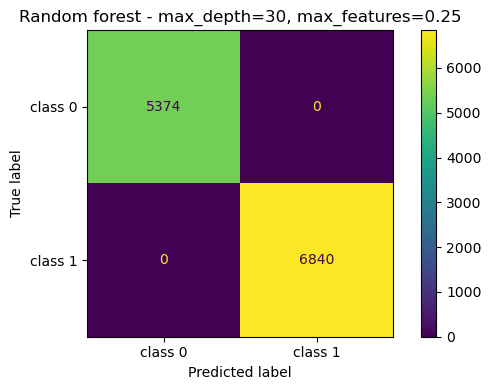

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = Pipeline(steps=[('preprocessor', preprocessor)]) # for now we only preprocess 
                                                       # later on we will add other steps here
clf.set_output(transform='pandas')

X_train_prep = clf.fit_transform(X_train)
X_test_prep = clf.transform(X_test)

# Create a Random Forest Classifier model
rf_classifier = RandomForestClassifier(max_depth=30, max_features=0.25, random_state=42)

# Train the model
rf_classifier.fit(X_train_prep, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test_prep)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(f'F1 score: {fbeta_score(y_test, y_pred, beta=1)}')

cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(cm,display_labels=['class 0', 'class 1'])
fig, ax = plt.subplots(figsize=(6,4))
plt.title('Random forest - max_depth=30, max_features=0.25')
disp.plot(ax=ax)
plt.tight_layout()
plt.show()

## 4.3 Support vector classification

In [74]:
# support vector classification

# function for the ML pipeline as outlined above 
def MLpipe_KFold_accuracy(X, y, preprocessor, ML_algo, param_grid):

    # lists to be returned 
    test_scores = []
    best_models = []
    model_svc = pd.DataFrame(columns=['best_parameter', 'train_score', 'test_score'])

    for i in range(5):
        # split the data
        X_other, X_test, y_other, y_test = train_test_split(X, y, train_size = 0.8, random_state = 42*i)

        # use KFold with 4 folds
        kf = KFold(n_splits=4,shuffle=True,random_state=42*i)

        pipe = make_pipeline(preprocessor,ML_algo)

        # GridSearchCV, loop through all possible parameters
        # preprocess data and perform cross valifation
        grid = GridSearchCV(pipe, param_grid=param_grid,scoring='accuracy',
                        cv=kf, return_train_score = True, n_jobs=-1, verbose=3) # return_train_score = True, n_jobs=-1, verbose=True
        
        grid.fit(X_other, y_other)
        results = pd.DataFrame(grid.cv_results_)

        # calculate and save the test score
        final_model = grid.best_estimator_
        train_accuracy= grid_search.score(X_other, y_other)
        y_test_pred = final_model.predict(X_test)
        test_scores.append(accuracy_score(y_test,y_test_pred)) # calculate the rmse
        best_models.append(grid.best_params_) # save the best param 

        model_svc.loc[len(model_svc)] = [grid.best_params_, train_accuracy, accuracy_score(y_test,y_test_pred)]

    return test_scores, best_models, results, model_svc

param_grid = {
    'svc__gamma': [1e-2, 1e-1, 1e1, 1e3],  # SVR
    'svc__C': [1e-1, 1e0, 1e1, 1e2]
}
ML_algo = SVC(kernel='poly', class_weight='balanced', random_state=42)

print("___________Model {}___________".format('Support Vector Classification'))
test_scores, best_models, res_svc, model_svc = MLpipe_KFold_accuracy(X, y, preprocessor, ML_algo, param_grid)

# Print the test scores
print("Test Scores:", test_scores)

# Calculate and print the mean and standard deviation of the test scores
mean_accuracy = np.mean(test_scores)
std_accuracy = np.std(test_scores)

res_accuracy.loc[len(res_accuracy)] = ['Support Vector Classification', mean_accuracy, std_accuracy]

print("Mean accuracy: {}".format(mean_accuracy))
print("Standard Deviation of accuracy: {}".format(std_accuracy))
print(model_svc)

___________Model Support Vector Classification___________
Fitting 4 folds for each of 16 candidates, totalling 64 fits


[CV 1/4] END svc__C=0.1, svc__gamma=10.0;, score=(train=1.000, test=1.000) total time=  12.2s
[CV 2/4] END svc__C=0.1, svc__gamma=10.0;, score=(train=1.000, test=1.000) total time=  13.0s
[CV 3/4] END svc__C=0.1, svc__gamma=10.0;, score=(train=1.000, test=1.000) total time=  10.7s
[CV 4/4] END svc__C=0.1, svc__gamma=10.0;, score=(train=1.000, test=1.000) total time=  10.5s
[CV 1/4] END svc__C=0.1, svc__gamma=1000.0;, score=(train=1.000, test=1.000) total time=   9.9s
[CV 2/4] END svc__C=0.1, svc__gamma=0.1;, score=(train=0.999, test=0.999) total time=  33.1s
[CV 4/4] END svc__C=0.1, svc__gamma=0.1;, score=(train=0.999, test=0.999) total time=  34.2s
[CV 2/4] END svc__C=0.1, svc__gamma=1000.0;, score=(train=1.000, test=1.000) total time=  10.1s
[CV 1/4] END svc__C=0.1, svc__gamma=0.1;, score=(train=0.999, test=0.998) total time=  34.1s
[CV 3/4] END svc__C=0.1, svc__gamma=0.1;, score=(train=0.999, test=0.999) total time=  35.2s
[CV 3/4] END svc__C=0.1, svc__gamma=1000.0;, score=(train=1.

In [76]:
res_test_score.loc[len(res_test_score)] = ['SVC', np.mean(test_scores), np.std(test_scores)]
res_test_score

,Model,mean_test,std_test
0,Logistic Regression,0.861978,0.001789
1,Random Forest,0.999951,0.000073
2,KNN,0.999967,0.000045
3,XGBoost,0.999018,0.000201
4,SVC,0.999935,0.000131


In [69]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = Pipeline(steps=[('preprocessor', preprocessor)]) # for now we only preprocess 
                                                       # later on we will add other steps here
clf.set_output(transform='pandas')

X_train_prep = clf.fit_transform(X_train)
X_test_prep = clf.transform(X_test)

# Create an SVC model
svc_model = SVC()

# Define hyperparameters to tune and their possible values
param_grid = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__kernel': ['linear', 'rbf', 'poly'],
    'svc__degree': [2, 3, 4],
    'svc__gamma': ['scale', 'auto'],
}

# Create GridSearchCV
grid_search = GridSearchCV(estimator=svc_model, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train_prep, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Make predictions on the test set using the best model
y_pred = grid_search.best_estimator_.predict(X_test_prep)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")


# Display classification report
#print("Classification Report:\n", classification_report(y_test, y_pred))

## 4.4 KNN

In [13]:
# knn
param_grid = {
    'kneighborsclassifier__n_neighbors': [3,9,12,15,30,50,100]  # knn
}
ML_algo = KNeighborsClassifier()

print("___________Model {}___________".format('knn'))
test_scores, best_models, res_knn, model_knn = MLpipe_KFold_accuracy(X, y, preprocessor, ML_algo, param_grid)

# Print the test scores
print("Test Scores:", test_scores)

# Calculate and print the mean and standard deviation of the test scores
mean_accuracy = np.mean(test_scores)
std_accuracy = np.std(test_scores)

res_accuracy.loc[len(res_accuracy)] = ['KNN', mean_accuracy, std_accuracy]

print("Mean accuracy: {}".format(mean_accuracy))
print("Standard Deviation of accuracy: {}".format(std_accuracy))

___________Model knn___________
---------Random State = 0---------
Fitting 4 folds for each of 7 candidates, totalling 28 fits
[CV 1/4] END kneighborsclassifier__n_neighbors=9;, score=(train=0.999, test=0.998) total time=  14.7s
[CV 4/4] END kneighborsclassifier__n_neighbors=9;, score=(train=1.000, test=0.999) total time=  14.7s
[CV 1/4] END kneighborsclassifier__n_neighbors=3;, score=(train=1.000, test=1.000) total time=  14.7s
[CV 2/4] END kneighborsclassifier__n_neighbors=3;, score=(train=1.000, test=1.000) total time=  14.6s
[CV 2/4] END kneighborsclassifier__n_neighbors=12;, score=(train=0.999, test=0.999) total time=  14.6s
[CV 1/4] END kneighborsclassifier__n_neighbors=12;, score=(train=0.999, test=0.998) total time=  15.0s
[CV 3/4] END kneighborsclassifier__n_neighbors=9;, score=(train=1.000, test=0.999) total time=  14.6s
[CV 2/4] END kneighborsclassifier__n_neighbors=9;, score=(train=1.000, test=1.000) total time=  14.9s
[CV 3/4] END kneighborsclassifier__n_neighbors=3;, scor

In [ ]:
#print(res_grid)

In [55]:
model_knn

,best_parameter,train_score,test_score
0,{'kneighborsclassifier__n_neighbors': 3},1.0,1.000000
1,{'kneighborsclassifier__n_neighbors': 3},1.0,1.000000
2,{'kneighborsclassifier__n_neighbors': 3},1.0,0.999918
3,{'kneighborsclassifier__n_neighbors': 3},1.0,0.999918
4,{'kneighborsclassifier__n_neighbors': 3},1.0,1.000000


In [32]:
res_test_score.loc[len(res_test_score)] = ['KNN', model_knn['test_score'].mean(), model_knn['test_score'].std()]
res_test_score

,Model,mean_test,std_test
0,Logistic Regression,0.861978,0.001789
1,XGBoost,0.999689,0.000157
2,KNN,0.999967,0.000045


### 4.4.1 KNN w/ distance

In [70]:
# knn
param_grid = {
    'kneighborsclassifier__n_neighbors': [3],
    'kneighborsclassifier__weights': ['uniform', 'distance'] # knn
}
ML_algo = KNeighborsClassifier()

print("___________Model {}___________".format('knn'))
test_scores, best_models, res_knn, model_knn = MLpipe_KFold_accuracy(X, y, preprocessor, ML_algo, param_grid)

# Print the test scores
print("Test Scores:", test_scores)

# Calculate and print the mean and standard deviation of the test scores
mean_accuracy = np.mean(test_scores)
std_accuracy = np.std(test_scores)

res_accuracy.loc[len(res_accuracy)] = ['KNN', mean_accuracy, std_accuracy]

print("Mean accuracy: {}".format(mean_accuracy))
print("Standard Deviation of accuracy: {}".format(std_accuracy))

___________Model knn___________
---------Random State = 0---------
Fitting 4 folds for each of 2 candidates, totalling 8 fits
[CV 2/4] END kneighborsclassifier__n_neighbors=3, kneighborsclassifier__weights=distance;, score=(train=1.000, test=1.000) total time=  11.2s
[CV 4/4] END kneighborsclassifier__n_neighbors=3, kneighborsclassifier__weights=distance;, score=(train=1.000, test=1.000) total time=  11.2s
[CV 1/4] END kneighborsclassifier__n_neighbors=3, kneighborsclassifier__weights=distance;, score=(train=1.000, test=1.000) total time=  11.4s
[CV 3/4] END kneighborsclassifier__n_neighbors=3, kneighborsclassifier__weights=distance;, score=(train=1.000, test=1.000) total time=  11.4s
[CV 3/4] END kneighborsclassifier__n_neighbors=3, kneighborsclassifier__weights=uniform;, score=(train=1.000, test=1.000) total time=  11.6s
[CV 1/4] END kneighborsclassifier__n_neighbors=3, kneighborsclassifier__weights=uniform;, score=(train=1.000, test=1.000) total time=  11.6s
[CV 4/4] END kneighborsc

## 4.5 xgboost

In [29]:
# xgboost

# Define hyperparameter grid for tuning
param_grid = {
    'xgbclassifier__max_depth': [3, 5, 7, 10],
    'xgbclassifier__min_child_weight': [1, 3, 5],
    'xgbclassifier__learning_rate': [0.1],
    'xgbclassifier__lambda': [0.01, 0.1, 1],  # reduce overfitting
    'xgbclassifier__alpha': [0.01, 0.1, 1]  # Used for high dimensionality
}
pg = ParameterGrid(param_grid)

# Train the pipeline on five different random states
random_states = [42, 123, 456, 789, 101]
train_scores = []
test_scores = []
best_models = []
test_sets = []

for random_state in random_states:
    print(f'_________Random State = {random_state}_________')
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    # use KFold with 4 folds
    kf = KFold(n_splits=4,shuffle=True,random_state=random_state)

    # Fit the ColumnTransformer on the training data
    X_train_transformed = preprocessor.fit_transform(X_train)

    # Create XGBoost model
    model = XGBClassifier(random_state=random_state)

    # define pipeline
    pipeline = make_pipeline(preprocessor, model)

    # Create GridSearchCV
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='accuracy', cv=kf, return_train_score=True, verbose=3)

    # Fit the model
    grid_search.fit(X_train, y_train, xgbclassifier__eval_metric="logloss", xgbclassifier__early_stopping_rounds=10, 
                    xgbclassifier__eval_set=[(preprocessor.transform(X_test), y_test)], xgbclassifier__verbose=False)

    # Save train and test scores
    train_accuracy= grid_search.score(X_train, y_train)
    test_accuracy = grid_search.score(X_test, y_test)

    # Save test sets
    test_set_df = pd.DataFrame(data=np.column_stack((X_test, y_test)), columns=X.columns.tolist() + ['target_column'])
    test_sets.append(test_set_df)

    train_scores.append(train_accuracy)
    test_scores.append(test_accuracy)
    best_models.append(grid_search.best_estimator_)
    res_xgb = grid_search.cv_results_

    print(f"Random State: {random_state},'Best Model': {grid_search.best_estimator_}, Train Score: {train_accuracy:.4f}, Test Score: {test_accuracy:.4f}")

# Save train and test scores
scores_df = pd.DataFrame({'Random State': random_states, 'Best Model': best_models, 'Train Score': train_scores, 'Test Score': test_scores})


_________Random State = 42_________
Fitting 4 folds for each of 108 candidates, totalling 432 fits
[CV 1/4] END xgbclassifier__alpha=0.01, xgbclassifier__lambda=0.01, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=3, xgbclassifier__min_child_weight=1;, score=(train=0.924, test=0.922) total time=   2.2s
[CV 2/4] END xgbclassifier__alpha=0.01, xgbclassifier__lambda=0.01, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=3, xgbclassifier__min_child_weight=1;, score=(train=0.918, test=0.914) total time=   2.4s
[CV 3/4] END xgbclassifier__alpha=0.01, xgbclassifier__lambda=0.01, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=3, xgbclassifier__min_child_weight=1;, score=(train=0.919, test=0.921) total time=   2.5s
[CV 4/4] END xgbclassifier__alpha=0.01, xgbclassifier__lambda=0.01, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=3, xgbclassifier__min_child_weight=1;, score=(train=0.908, test=0.910) total time=   2.6s
[CV 1/4] END xgbclassifier__alpha

In [40]:
scores_df

,Random State,Best Model,Train Score,Test Score
0,42,"(ColumnTransformer(transformers=[('onehot',\n ...",0.999959,0.999427
1,123,"(ColumnTransformer(transformers=[('onehot',\n ...",0.999980,0.999836
2,456,"(ColumnTransformer(transformers=[('onehot',\n ...",0.999959,0.999754
3,789,"(ColumnTransformer(transformers=[('onehot',\n ...",0.999980,0.999673
4,101,"(ColumnTransformer(transformers=[('onehot',\n ...",0.999939,0.999754


In [43]:
print('test mean: ', scores_df['Test Score'].mean(), ', test std: ', scores_df['Test Score'].std())

test mean:  0.9996888816112659 , test std:  0.00015748636041976654


In [31]:
res_test_score.loc[len(res_test_score)] = ['XGBoost', scores_df['Test Score'].mean(), scores_df['Test Score'].std()]
res_test_score

,Model,mean_test,std_test
0,Logistic Regression,0.861978,0.001789
1,XGBoost,0.999689,0.000157


## 4.6 model results

In [40]:
result_scores = pd.read_csv('results/result_scores.csv')
result_scores

,Model,mean_test,std_test
0,Logistic Regression,0.861978,0.001789
1,Random Forest,0.999951,0.000073
2,KNN,0.999967,0.000045
3,XGBoost,0.999689,0.000157
4,SVC,0.999935,0.000131


In [93]:
result_scores['num_of_std'] = ((result_scores['mean_test'] - baseline_acc) / result_scores['std_test'])
result_scores

,Model,mean_test,std_test,num_of_std
0,Logistic Regression,0.861978,0.001789,168.789771
1,Random Forest,0.999951,0.000073,6026.546579
2,KNN,0.999967,0.000045,9776.753340
3,XGBoost,0.999689,0.000157,2800.483441
4,SVC,0.999935,0.000131,3358.182445


In [79]:
res_test_score

,Model,mean_test,std_test
0,Logistic Regression,0.861978,0.001789
1,Random Forest,0.999951,0.000073
2,KNN,0.999967,0.000045
3,XGBoost,0.999018,0.000201
4,SVC,0.999935,0.000131


# 5. Results

## 5.1 Comparing with baseline

In [38]:
# predict all class as poisonous
baseline_pred = np.ones(len(y_test))
baseline_acc = accuracy_score(y_test, baseline_pred)

print(f"Baseline Accuracy: {baseline_acc:.5f}")

Baseline Accuracy: 0.56001


In [77]:
res_test_score

,Model,mean_test,std_test
0,Logistic Regression,0.861978,0.001789
1,Random Forest,0.999951,0.000073
2,KNN,0.999967,0.000045
3,XGBoost,0.999018,0.000201
4,SVC,0.999935,0.000131


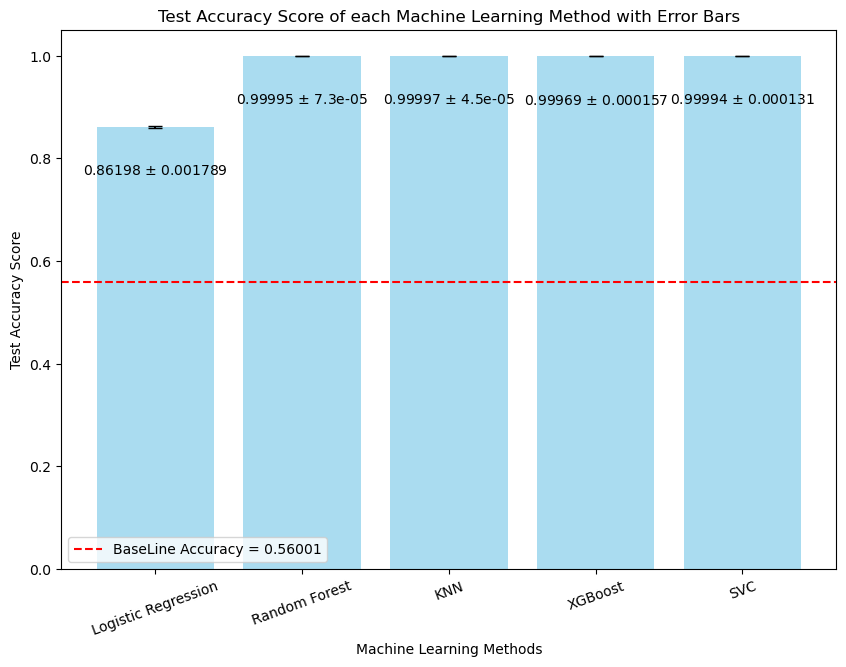

In [92]:

test_mean = np.array(result_scores['mean_test'])  #lr, rf, knn, xgboost
test_std = np.array(result_scores['std_test'])  #lr, rf, knn, xgboost
labels = result_scores['Model']

# Plot the mean values
plt.figure(figsize=(10, 7))
plt.bar(labels, test_mean, yerr=test_std, capsize=5, color='skyblue', alpha=0.7)

plt.axhline(y=baseline_acc, linestyle='--', color='red', label='BaseLine Accuracy = {:.5f}'.format(baseline_acc))

# Add labels and title
plt.legend()
plt.xlabel('Machine Learning Methods')
plt.xticks(rotation=20)
plt.ylabel('Test Accuracy Score')
plt.title('Test Accuracy Score of each Machine Learning Method with Error Bars')

# Add custom labels for error bars (optional)
for i, (x, y, y_err) in enumerate(zip(labels, test_mean, test_std)):
    plt.text(x, y-0.1, f'{y:.5f} $\pm$ {y_err}', ha='center', va='bottom')

# Show the plot
plt.show()

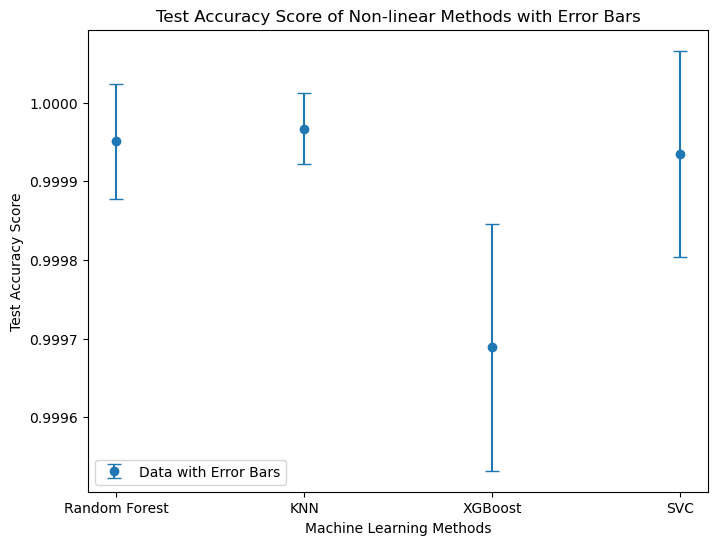

In [57]:
plt.figure(figsize=(8, 6))
plt.errorbar(labels[1:], test_mean[1:], yerr=test_std[1:], fmt='o', capsize=5, label='Data with Error Bars')

plt.xlabel('Machine Learning Methods')
plt.ylabel('Test Accuracy Score')
plt.title('Test Accuracy Score of Non-linear Methods with Error Bars')
plt.legend(loc=3)

#for i, (x, y, y_err) in enumerate(zip(labels[1:], test_mean[1:], test_std[1:])):
#    plt.text(x, y + y_err + 0.1, f'{y} $\pm$ {y_err}', ha='center', va='bottom')

plt.show()

# 6. Best Model

## 6.1 KNN

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1030)

clf = Pipeline(steps=[('preprocessor', preprocessor)]) # for now we only preprocess 
                                                       # later on we will add train steps here
clf.set_output(transform='pandas')

X_train_prep = clf.fit_transform(X_train) # save for later use
X_test_prep = clf.transform(X_test)
print(X_train_prep.shape)

# choose KNN as the final model
final_model = KNeighborsClassifier(n_neighbors=3)
final_model.fit(X_train_prep, y_train)

(48855, 124)


KNeighborsClassifier(n_neighbors=3)

In [72]:
y_pred = final_model.predict(X_test_prep)
print(f'test set accuracy score: {final_model.score(X_test_prep, y_test)}')

test set accuracy score: 0.9999181267398067


In [81]:
f1_score(y_pred, y_test)

0.9999264651812633

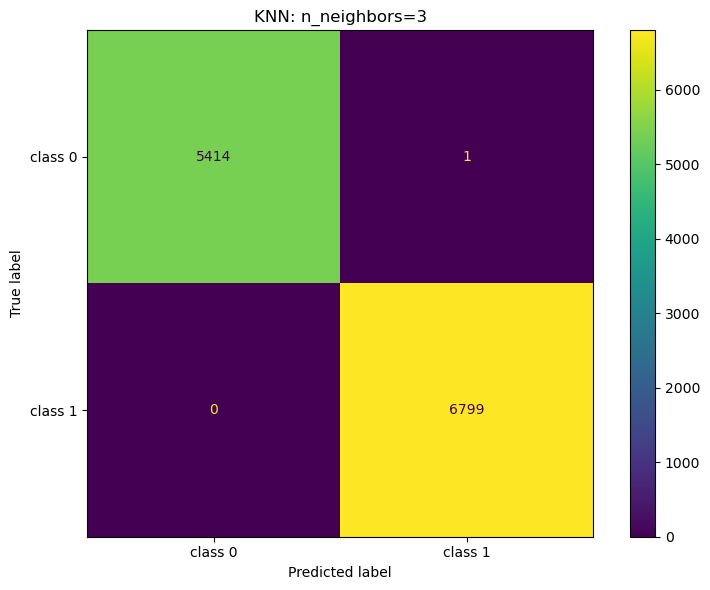

In [74]:
cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(cm,display_labels=['class 0', 'class 1'])
fig, ax = plt.subplots(figsize=(8,6))
plt.title('KNN: n_neighbors=3')
disp.plot(ax=ax)
plt.tight_layout()
plt.show()

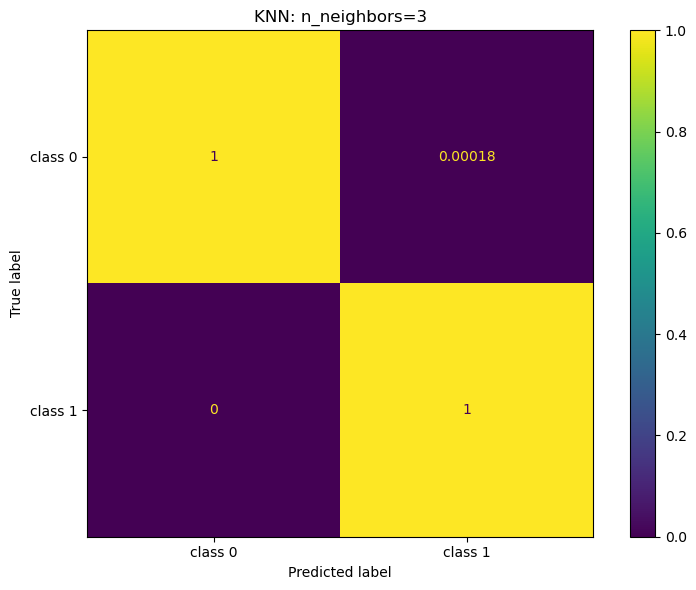

In [76]:
cm = confusion_matrix(y_test,y_pred,normalize='true')
disp = ConfusionMatrixDisplay(cm,display_labels=['class 0', 'class 1'])
fig, ax = plt.subplots(figsize=(8,6))
plt.title('KNN: n_neighbors=3')
disp.plot(ax=ax)
plt.tight_layout()
plt.show()

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

clf = Pipeline(steps=[('preprocessor', preprocessor)]) # for now we only preprocess 
                                                       # later on we will add train steps here
clf.set_output(transform='pandas')

X_train_prep = clf.fit_transform(X_train) # save for later use
X_test_prep = clf.transform(X_test)
print(X_train_prep.shape)

# choose KNN as the final model
final_model = KNeighborsClassifier(n_neighbors=3)
final_model.fit(X_train_prep, y_train)

y_pred = final_model.predict(X_test_prep)
print(f'test set accuracy score: {final_model.score(X_test_prep, y_test)}')

(48855, 124)
test set accuracy score: 1.0


In [85]:
f1_score(y_pred, y_test)

1.0

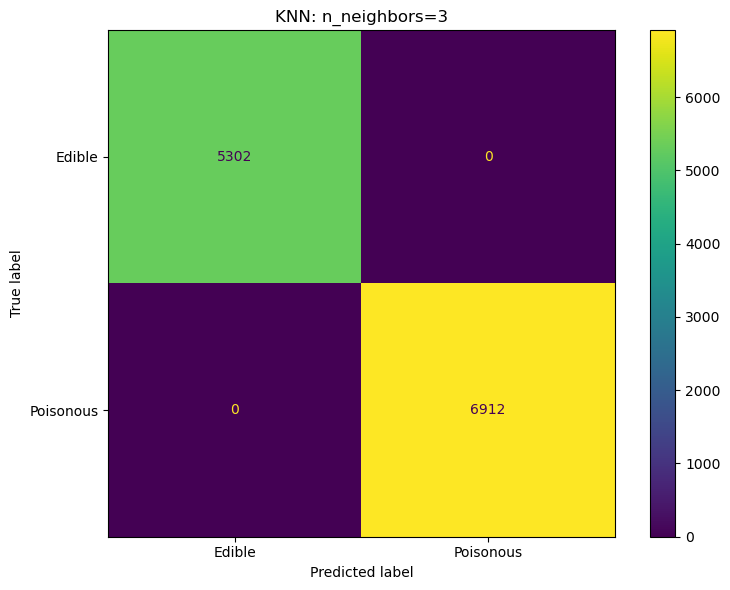

In [87]:
cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(cm,display_labels=['Edible', 'Poisonous'])
fig, ax = plt.subplots(figsize=(8,6))
plt.title('KNN: n_neighbors=3')
disp.plot(ax=ax)
plt.tight_layout()
plt.show()

# 7. Feature Importance

## 7.1 Global feature importance

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

clf = Pipeline(steps=[('preprocessor', preprocessor)]) # for now we only preprocess 
                                                       # later on we will add train steps here
clf.set_output(transform='pandas')

X_train_prep = clf.fit_transform(X_train) # save for later use
X_test_prep = clf.transform(X_test)
print(X_train_prep.shape)

# choose KNN as the final model
final_model = KNeighborsClassifier(n_neighbors=3)
final_model.fit(X_train_prep, y_train)

(48855, 124)


KNeighborsClassifier(n_neighbors=3)

In [27]:
y_pred = final_model.predict(X_test_prep)
print(f'test set accuracy score: {final_model.score(X_test_prep, y_test)}')

test set accuracy score: 1.0


In [11]:
# your code here
np.random.seed(0)

ftr_names = X_test_prep.columns

nr_runs = 10
scores = np.zeros([len(ftr_names),nr_runs])

test_score = final_model.score(X_test_prep, y_test)
print('test score = ',test_score)
print('test baseline = ', baseline_acc)
# loop through the features
for i in range(len(ftr_names)):
    print('shuffling '+str(ftr_names[i]))
    acc_scores = []
    for j in range(nr_runs):
        X_test_shuffled = X_test_prep.copy()
        X_test_shuffled[ftr_names[i]] = np.random.permutation(X_test_prep[ftr_names[i]].values)
        acc_scores.append(final_model.score(X_test_shuffled,y_test))
    print('   shuffled test score:',np.around(np.mean(acc_scores),3),'+/-',np.around(np.std(acc_scores),3))
    scores[i] = acc_scores

test score =  1.0
test baseline =  0.5600130997216309
shuffling onehot__cap-shape_b
   shuffled test score: 1.0 +/- 0.0
shuffling onehot__cap-shape_c
   shuffled test score: 1.0 +/- 0.0
shuffling onehot__cap-shape_f
   shuffled test score: 1.0 +/- 0.0
shuffling onehot__cap-shape_o
   shuffled test score: 1.0 +/- 0.0
shuffling onehot__cap-shape_p
   shuffled test score: 1.0 +/- 0.0
shuffling onehot__cap-shape_s
   shuffled test score: 1.0 +/- 0.0
shuffling onehot__cap-shape_x
   shuffled test score: 1.0 +/- 0.0
shuffling onehot__cap-surface_d
   shuffled test score: 1.0 +/- 0.0
shuffling onehot__cap-surface_e
   shuffled test score: 1.0 +/- 0.0
shuffling onehot__cap-surface_g
   shuffled test score: 1.0 +/- 0.0
shuffling onehot__cap-surface_h
   shuffled test score: 1.0 +/- 0.0
shuffling onehot__cap-surface_i
   shuffled test score: 1.0 +/- 0.0
shuffling onehot__cap-surface_k
   shuffled test score: 1.0 +/- 0.0
shuffling onehot__cap-surface_l


OpenBLAS warning: precompiled NUM_THREADS exceeded, adding auxiliary array for thread metadata.
To avoid this warning, please rebuild your copy of OpenBLAS with a larger NUM_THREADS setting
or set the environment variable OPENBLAS_NUM_THREADS to 256 or lower
OpenBLAS warning: precompiled NUM_THREADS exceeded, adding auxiliary array for thread metadata.
To avoid this warning, please rebuild your copy of OpenBLAS with a larger NUM_THREADS setting
or set the environment variable OPENBLAS_NUM_THREADS to 256 or lower
OpenBLAS warning: precompiled NUM_THREADS exceeded, adding auxiliary array for thread metadata.
To avoid this warning, please rebuild your copy of OpenBLAS with a larger NUM_THREADS setting
or set the environment variable OPENBLAS_NUM_THREADS to 256 or lower


: 

In [ ]:
sorted_indcs = np.argsort(np.abs(np.mean(scores,axis=1)-test_score))
plt.rcParams.update({'font.size': 11})
plt.figure(figsize=(10,6))
plt.boxplot(scores[sorted_indcs[-10:]].T,labels=ftr_names[sorted_indcs[-10:]],vert=False)
plt.axvline(test_score,label='test score')
plt.title("Permutation Importances (test set)")
plt.xlabel('score with perturbed feature')
plt.legend()
plt.tight_layout()
plt.show()

## 7.2 Local Feature importance (SHAP)

In [28]:
shap.initjs() # required for visualizations later on
# create the explainer object with the random forest model
explainer = shap.TreeExplainer(final_model)
# transform the test set
X_test_transformed = X_test_prep
print(np.shape(X_test_transformed))
# calculate shap values on the first 1000 points in the test
shap_values = explainer.shap_values(X_test_transformed[:1000])
print(np.shape(shap_values))

InvalidModelError: Model type not yet supported by TreeExplainer: <class 'sklearn.neighbors._classification.KNeighborsClassifier'>

In [ ]:
shap_summary = np.abs(shap_values[1])+np.abs(shap_values[0]) 
indcs = np.argsort(shap_summary)
shap_summary[indcs]

plt.figure(figsize=(10,6))
plt.barh(feature_names[indcs[-10:]],shap_summary[indcs[-10:]])
plt.title('SHAP value of 10 most important features')
plt.xlabel('mean(|SHAP value|)')
plt.show()

In [4]:
%%capture cap --no-stderr
print('stuff')
with open('model_output/output.txt', 'w') as f:
    f.write(cap.stdout)